In [1]:
import os
import sys
import random
import math
import time
import numpy as np
from tqdm import tqdm
import pandas as pd
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from config import DSBConfig
import utils
from utils import DSBDataset
import mask_rcnn as modellib
import visualize
from mask_rcnn import log

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cut_off = 0.5):
    lab_img = label(x > cut_off)
    if lab_img.max() < 1:
        # ensure at least one prediction per image
        lab_img[0,0] = 1
    for i in range(1, lab_img.max() +1):
        yield rle_encoding(lab_img==i)
        
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

def create_mask(prob_mask):
    max_idx = np.argmax(prob_mask, axis=2)
    h, w, counts = prob_mask.shape
    mask = np.zeros((h, w, counts), dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            idx = max_idx[i, j]
            if prob_mask[i, j, idx] == -1:
                mask[i, j, idx] == 0
            else:
                mask[i, j, idx] = 1
    return mask

In [3]:
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = "./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5"

TEST_PATH = '../dataset/DSB/test/'

In [4]:
# Get train and test IDs
test_ids = next(os.walk(TEST_PATH))[1]

In [5]:
config = DSBConfig()
config.IMAGE_MAX_DIM = 320

class InferenceConfig(DSBConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
inference_config = InferenceConfig()

config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  320
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           DSB
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2000


In [6]:
# Recreate the model in inference mode
model = modellib.MaskRCNN(
    mode="inference", 
    config=inference_config,
    model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/dsb20180309T1156/mask_rcnn_dsb_0010.h5


In [7]:
results = []
for ids in tqdm(test_ids):
    test_img = imread(TEST_PATH + ids + "/images/" +ids + ".png")[:, :, :3]
    r = model.detect([test_img], verbose=1)[0]
    h, w , counts = r["masks"].shape
    prob_masks = np.zeros((h, w, counts))
    for i in range(counts):
        prob_mask = np.where(r["masks"][:, :, i] == 1, r["scores"][i], -1)
        prob_masks[:, :, i] = prob_mask
    r["ids"] = ids
    r["prob_masks"] = prob_masks
    r["masks"] = create_mask(prob_masks)
    results.append(r)

  0%|          | 0/65 [00:00<?, ?it/s]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   79.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  -24.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


  2%|▏         | 1/65 [00:02<02:08,  2.01s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


  3%|▎         | 2/65 [00:02<01:14,  1.18s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


  5%|▍         | 3/65 [00:02<00:57,  1.07it/s]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:   76.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -34.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


  6%|▌         | 4/65 [00:03<01:00,  1.00it/s]

Processing 1 images
image                    shape: (519, 162, 3)         min:    1.00000  max:  205.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   77.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


  8%|▊         | 5/65 [00:04<00:58,  1.03it/s]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  126.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    1.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


  9%|▉         | 6/65 [00:06<01:03,  1.08s/it]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 11%|█         | 7/65 [00:08<01:06,  1.15s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 12%|█▏        | 8/65 [00:08<01:00,  1.06s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 14%|█▍        | 9/65 [00:10<01:04,  1.15s/it]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 15%|█▌        | 10/65 [00:12<01:11,  1.30s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 17%|█▋        | 11/65 [00:13<01:05,  1.21s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 18%|█▊        | 12/65 [00:14<01:02,  1.17s/it]

Processing 1 images
image                    shape: (390, 239, 3)         min:    0.00000  max:   81.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -26.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  390.00000


 20%|██        | 13/65 [00:15<01:02,  1.20s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  109.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -16.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 22%|██▏       | 14/65 [00:16<01:00,  1.18s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:  121.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:   17.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 23%|██▎       | 15/65 [00:16<00:56,  1.13s/it]

Processing 1 images
image                    shape: (260, 347, 3)         min:   26.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000


 25%|██▍       | 16/65 [00:18<00:56,  1.16s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   93.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  -10.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 26%|██▌       | 17/65 [00:18<00:53,  1.11s/it]

Processing 1 images
image                    shape: (520, 348, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000


 28%|██▊       | 18/65 [00:20<00:54,  1.16s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 29%|██▉       | 19/65 [00:21<00:52,  1.13s/it]

Processing 1 images
image                    shape: (520, 348, 3)         min:    3.00000  max:  186.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   75.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000


 31%|███       | 20/65 [00:23<00:52,  1.16s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  177.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   39.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 32%|███▏      | 21/65 [00:24<00:52,  1.18s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 34%|███▍      | 22/65 [00:25<00:49,  1.16s/it]

Processing 1 images
image                    shape: (519, 161, 3)         min:    5.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 35%|███▌      | 23/65 [00:26<00:47,  1.14s/it]

Processing 1 images
image                    shape: (520, 696, 3)         min:   11.00000  max:  225.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  119.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 37%|███▋      | 24/65 [00:27<00:47,  1.15s/it]

Processing 1 images
image                    shape: (520, 696, 3)         min:   11.00000  max:  230.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  125.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 38%|███▊      | 25/65 [00:29<00:47,  1.18s/it]

Processing 1 images
image                    shape: (519, 161, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 40%|████      | 26/65 [00:30<00:45,  1.16s/it]

Processing 1 images
image                    shape: (520, 348, 3)         min:    0.00000  max:  201.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   81.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000


 42%|████▏     | 27/65 [00:33<00:46,  1.23s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    8.00000  max:  192.00000
molded_images            shape: (1, 256, 256, 3)      min: -115.70000  max:   88.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 43%|████▎     | 28/65 [00:33<00:44,  1.20s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  150.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 45%|████▍     | 29/65 [00:36<00:45,  1.26s/it]

Processing 1 images
image                    shape: (260, 347, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000


 46%|████▌     | 30/65 [00:37<00:43,  1.24s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   82.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  -21.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 48%|████▊     | 31/65 [00:37<00:41,  1.21s/it]

Processing 1 images
image                    shape: (519, 253, 3)         min:   10.00000  max:  225.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  119.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 49%|████▉     | 32/65 [00:38<00:39,  1.20s/it]

Processing 1 images
image                    shape: (520, 696, 3)         min:   11.00000  max:  222.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  116.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 51%|█████     | 33/65 [00:40<00:39,  1.22s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 52%|█████▏    | 34/65 [00:41<00:38,  1.23s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  108.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:    4.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 54%|█████▍    | 35/65 [00:42<00:36,  1.21s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  109.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -14.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 55%|█████▌    | 36/65 [00:43<00:34,  1.20s/it]

Processing 1 images
image                    shape: (519, 162, 3)         min:    3.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 57%|█████▋    | 37/65 [00:43<00:33,  1.18s/it]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  144.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 58%|█████▊    | 38/65 [00:44<00:31,  1.18s/it]

Processing 1 images
image                    shape: (260, 347, 3)         min:    2.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000


 60%|██████    | 39/65 [00:45<00:30,  1.18s/it]

Processing 1 images
image                    shape: (524, 348, 3)         min:    0.00000  max:  253.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  138.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  524.00000


 62%|██████▏   | 40/65 [00:47<00:29,  1.18s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  101.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   -2.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 63%|██████▎   | 41/65 [00:47<00:27,  1.16s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    1.00000  max:  153.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   23.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 65%|██████▍   | 42/65 [00:48<00:26,  1.16s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 66%|██████▌   | 43/65 [00:50<00:25,  1.17s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 68%|██████▊   | 44/65 [00:50<00:24,  1.15s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  149.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 69%|██████▉   | 45/65 [00:52<00:23,  1.17s/it]

Processing 1 images
image                    shape: (519, 253, 3)         min:   11.00000  max:  211.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  106.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 71%|███████   | 46/65 [00:53<00:22,  1.16s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  192.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   35.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 72%|███████▏  | 47/65 [00:54<00:20,  1.17s/it]

Processing 1 images
image                    shape: (512, 640, 3)         min:    0.00000  max:  186.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   56.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  640.00000


 74%|███████▍  | 48/65 [00:56<00:19,  1.17s/it]

Processing 1 images
image                    shape: (520, 348, 3)         min:    5.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  520.00000


 75%|███████▌  | 49/65 [00:57<00:18,  1.16s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 77%|███████▋  | 50/65 [00:59<00:17,  1.18s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  245.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  141.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 78%|███████▊  | 51/65 [00:59<00:16,  1.16s/it]

Processing 1 images
image                    shape: (519, 253, 3)         min:    9.00000  max:  101.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:   -9.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 80%|████████  | 52/65 [01:00<00:15,  1.16s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  148.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 82%|████████▏ | 53/65 [01:02<00:14,  1.17s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 83%|████████▎ | 54/65 [01:02<00:12,  1.16s/it]

Processing 1 images
image                    shape: (512, 680, 3)         min:    0.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  146.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  680.00000


 85%|████████▍ | 55/65 [01:03<00:11,  1.16s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 86%|████████▌ | 56/65 [01:04<00:10,  1.15s/it]

Processing 1 images
image                    shape: (520, 696, 3)         min:   10.00000  max:  237.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  132.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  696.00000


 88%|████████▊ | 57/65 [01:05<00:09,  1.15s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:   89.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  -14.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 89%|████████▉ | 58/65 [01:05<00:07,  1.14s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:   10.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -113.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 91%|█████████ | 59/65 [01:06<00:06,  1.12s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 92%|█████████▏| 60/65 [01:06<00:05,  1.11s/it]

Processing 1 images
image                    shape: (260, 347, 3)         min:   28.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  347.00000


 94%|█████████▍| 61/65 [01:07<00:04,  1.10s/it]

Processing 1 images
image                    shape: (519, 253, 3)         min:   11.00000  max:  242.00000
molded_images            shape: (1, 256, 256, 3)      min: -123.70000  max:  137.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  519.00000


 95%|█████████▌| 62/65 [01:07<00:03,  1.10s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   95.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:   -8.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 97%|█████████▋| 63/65 [01:08<00:02,  1.08s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


 98%|█████████▊| 64/65 [01:08<00:01,  1.07s/it]

Processing 1 images
image                    shape: (256, 256, 3)         min:    9.00000  max:  255.00000
molded_images            shape: (1, 256, 256, 3)      min: -114.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


100%|██████████| 65/65 [01:09<00:00,  1.06s/it]


In [8]:
out_pred_list = []
for r in results:
    counts = len(r["scores"])
    for i in range(counts):
        enc = rle_encoding(r["masks"][:, :, i])
        out_pred_list+=[dict(ImageId=r["ids"], EncodedPixels = ' '.join(np.array(enc).astype(str)))]
out_pred_df = pd.DataFrame(out_pred_list)
out_pred_df.sample(3)

,EncodedPixels,ImageId
503,154976 8 155495 13 156014 17 156534 18 157054 ...,550450e4bff4036fd671decdc5d42fec23578198d6a2fd...
1630,229796 1 230304 12 230814 19 231325 27 231836 ...,44afae184c89e6ba55985b4d341acc1ae1e8b6ef963120...
923,1001 13 1519 17 2038 18 2558 18 3078 18 3598 1...,d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633f...


In [9]:
out_pred_df[['ImageId', 'EncodedPixels']].to_csv('predictions.csv', index = False)

Processing 1 images
image                    shape: (256, 256, 3)         min:    1.00000  max:   79.00000
molded_images            shape: (1, 256, 256, 3)      min: -122.70000  max:  -24.90000
image_metas              shape: (1, 10)               min:    0.00000  max:  256.00000


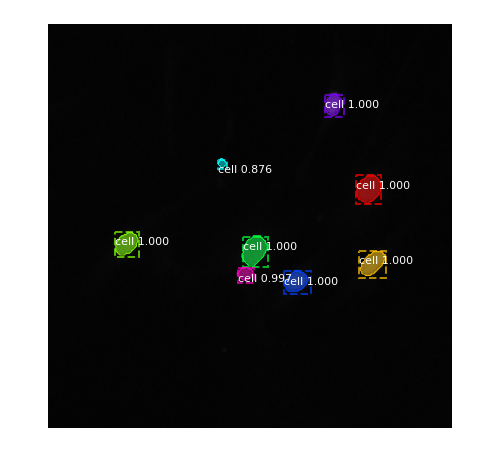

In [11]:
ids = 0
org_img = imread(TEST_PATH + test_ids[ids] + "/images/" +test_ids[ids] + ".png")[:, :, :3]
r = model.detect([org_img], verbose=1)[0]
visualize.display_instances(
    org_img,
    r['rois'],
    r['masks'],
    r['class_ids'], 
    ["BG", "cell"],
    r['scores'],
    ax=get_ax())